In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import torch

# load model
sold2 = KF.SOLD2(pretrained=True, config=None)

def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb

# read first image from left_cam
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB)
img = Image.fromarray(left_cam_reference_rgb, 'RGB') # type: PIL image i.e. np.array(img): 1080 x 1920 x 3 (RGB)
assert(np.array_equal(np.array(img), left_cam_reference_rgb))
img.save('left_cam_reference_rgb.png')


# read first image from right cam
data = pd.read_csv('../../journal_dataset/stereo-right-image.csv', nrows = 1)
raw_string = data['data'][0]
right_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string)
img = Image.fromarray(right_cam_reference_rgb, 'RGB')
img.save('right_cam_reference_rgb.png')
'''
# cv2.imread reads image in RGB but is returned in BGR
image = cv2.imread('left_cam_reference_rgb.png')
# cv2.imshow AUTO converts to RGB for display without changing underlying array
cv2.imshow("test", image)
cv2.waitKey(0)s
cv2.destroyAllWindows()
# image is np.array in BGR order vs. original array is in RGB order
assert(np.array_equal(image[0:5, 0:5, :], left_cam_reference_rgb[0:5, 0:5, :]))
'''

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/sold2_wireframe.pth" to /Users/chris/.cache/torch/hub/checkpoints/sold2_wireframe.pth
100.0%
/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_11105/1239367966.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_11105/1239367966.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


'\n# cv2.imread reads image in RGB but is returned in BGR\nimage = cv2.imread(\'left_cam_reference_rgb.png\')\n# cv2.imshow AUTO converts to RGB for display without changing underlying array\ncv2.imshow("test", image)\ncv2.waitKey(0)s\ncv2.destroyAllWindows()\n# image is np.array in BGR order vs. original array is in RGB order\nassert(np.array_equal(image[0:5, 0:5, :], left_cam_reference_rgb[0:5, 0:5, :]))\n'

In [2]:
def kornia_load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # loads saved image into 1080 x 1920 x 3 (BGR)
    # print('img.shape: {}'.format(img.shape))
    # plt.imshow(img) # colors are BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB order: 1080 x 1920 x 3 (RGB)
    #a = img[:, :, 0] / 255.0
    #print('img.shape: {}'.format(img.shape))
    #plt.imshow(img) # colors are RGB
    img = K.image_to_tensor(img).float() / 255.0 # convert to 3 x 1080 x 1920 (RGB)
    #b = img[0, :, :].numpy()
    #assert(np.allclose(a, b))
    #print('img.shape: {}'.format(img.shape))
    #out = K.tensor_to_image(img)
    #plt.imshow(out)
    return img

In [3]:
fname1 = 'left_cam_reference_rgb.png'
fname2 = 'right_cam_reference_rgb.png'

torch_left_ref = kornia_load_img(fname1)
torch_right_ref = kornia_load_img(fname2)

torch_left_ref.shape, torch_right_ref.shape

# convert the reference images to gray scale
torch_left_ref_gray = K.color.rgb_to_grayscale(torch_left_ref)
torch_right_ref_gray = K.color.rgb_to_grayscale(torch_right_ref)

In [4]:
# read images from csv without saving to PIL saved PNG
# check for equality
# read first image from left_cam 
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string)
print(left_cam_reference_rgb.shape)
left_cam_reference_rgb = K.image_to_tensor(left_cam_reference_rgb).float() / 255.0 # direct to RGB tensor (kornia_load_img converts from BGR to RGB first because read-in saved image is stored BGR)
print(left_cam_reference_rgb.shape)
assert(np.array_equal(left_cam_reference_rgb, torch_left_ref))
left_cam_reference_gray = K.color.rgb_to_grayscale(left_cam_reference_rgb)
assert(np.array_equal(left_cam_reference_gray, torch_left_ref_gray))

rgb.shape: (1080, 1920, 3)
(1080, 1920, 3)
torch.Size([3, 1080, 1920])


/tmp/ipykernel_200485/1239367966.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


In [5]:
# work on left camera
chunksize = 10 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string)
        img = K.image_to_tensor(rgb).float() / 255.0
        img = K.color.rgb_to_grayscale(img)
        imgs = torch.stack([torch_left_ref_gray, img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

/tmp/ipykernel_200485/1239367966.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)
rgb.shape: (1080, 1920, 3)


In [6]:
outputs.keys()
# detected line segments in ij coordinates convention.
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]


In [7]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

In [8]:
# plot lines

import copy
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

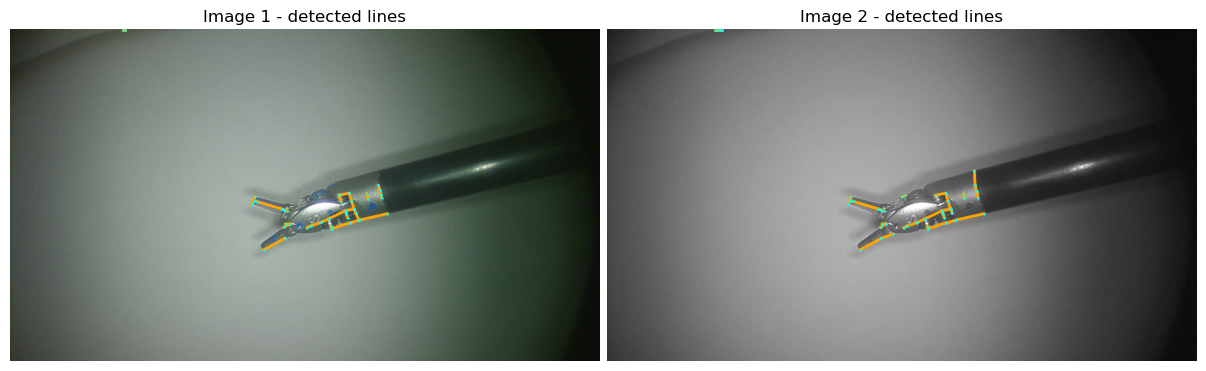

In [9]:
# plot detected lines
imgs_to_plot = [K.tensor_to_image(torch_left_ref), K.tensor_to_image(img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

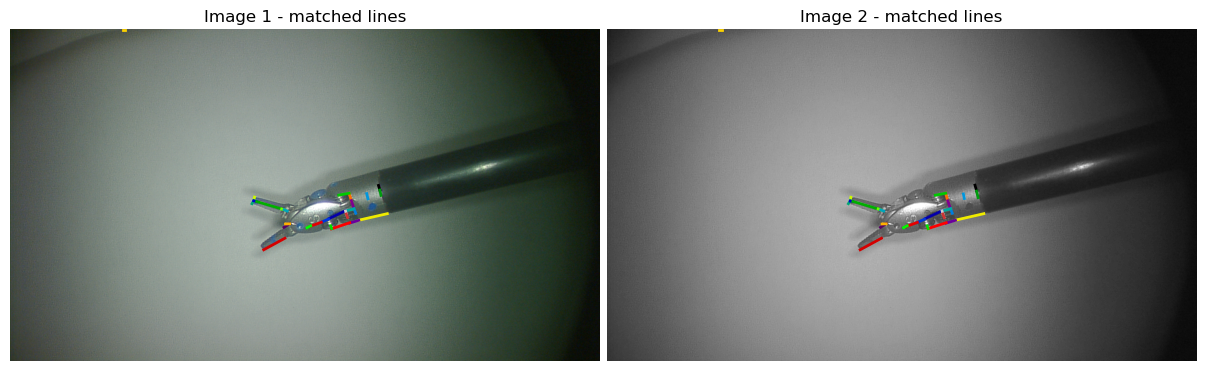

In [10]:
# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

In [11]:
outputs.keys()

dict_keys(['junction_heatmap', 'line_heatmap', 'dense_desc', 'line_segments'])

In [13]:
outputs['line_heatmap'].shape

torch.Size([2, 1080, 1920])

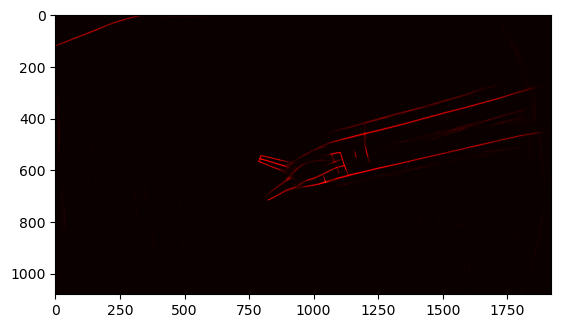

In [14]:
plt.imshow(np.asarray(outputs['line_heatmap'][0]), cmap = 'hot')

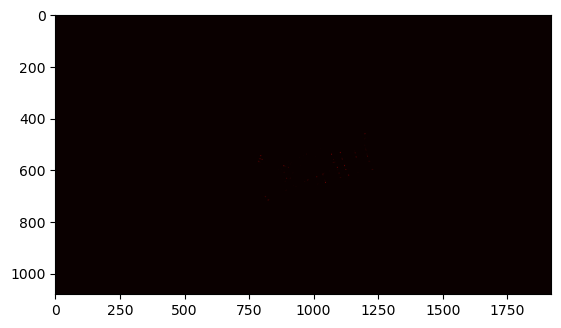

In [15]:
plt.imshow(np.asarray(outputs['junction_heatmap'][0]), cmap = 'hot')

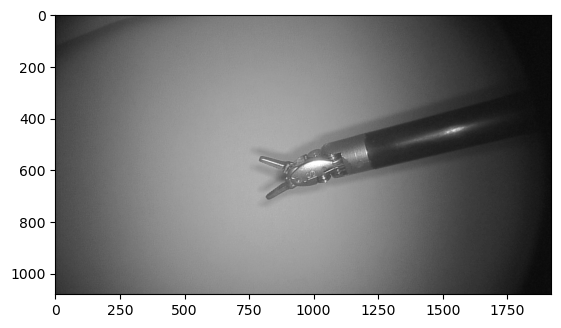

In [20]:
grey = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap = 'gray')

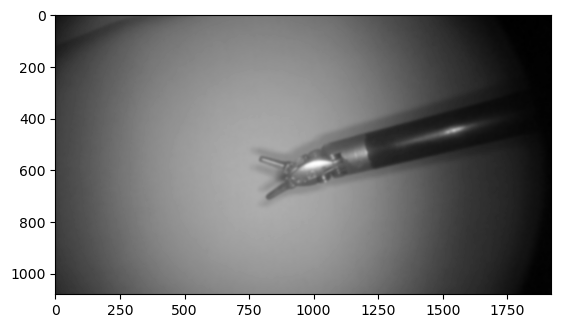

In [21]:
blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
plt.imshow(blur, cmap = 'gray')

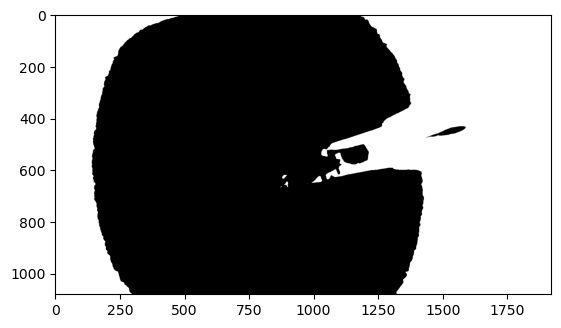

In [22]:

thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(mask, cmap = 'gray')

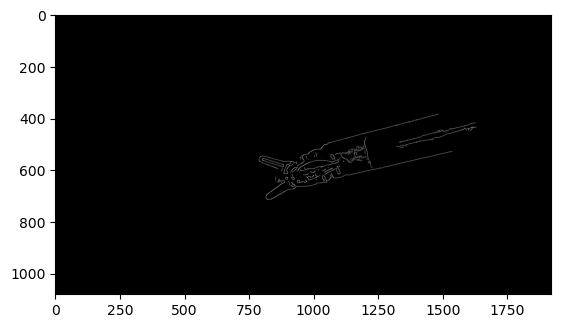

In [23]:
edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
plt.imshow(edges, cmap = 'gray')


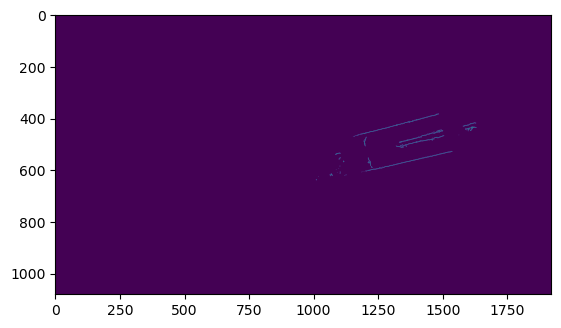

In [29]:
edges_and_mask = cv2.bitwise_and(edges, mask)
plt.imshow(edges_and_mask)


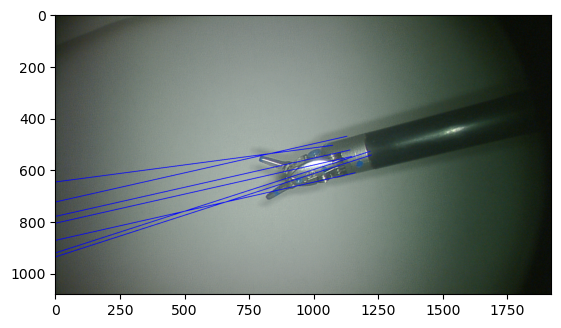

In [32]:

lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = 5, theta = 0.09, threshold = 100) 
lines = np.squeeze(lines)
# sort by max votes
sorted_lines = lines[(-lines[:, 2]).argsort()]
for i in range(sorted_lines.shape[0]):
    rho = sorted_lines[i, 0]
    theta = sorted_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(rgb, pt1, pt2, (0,0,255), 2)
plt.imshow(rgb)


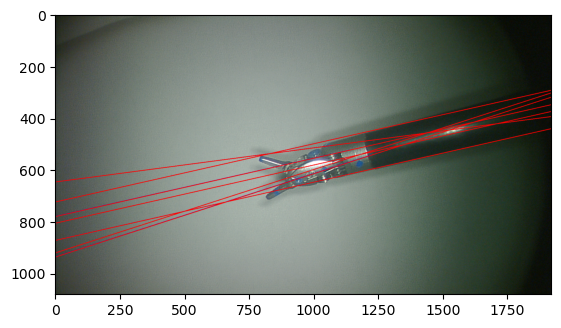

In [33]:

rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = 5, criterion = 'distance', method = 'complete')
theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = 0.09, criterion = 'distance', method = 'complete')

best_lines = []
checked_clusters = []
for i in range(sorted_lines.shape[0]):
    rho_cluster = rho_clusters[i]
    theta_cluster = theta_clusters[i]
    cluster = (rho_cluster, theta_cluster)
    if (cluster in checked_clusters):
        continue
    best_lines.append([lines[i, 0], lines[i, 1]])
    checked_clusters.append(cluster)

best_lines = np.asarray(best_lines)

for i in range(best_lines.shape[0]):
    rho = best_lines[i, 0]
    theta = best_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    cv2.line(rgb, pt1, pt2, (255,0,0), 2)
plt.imshow(rgb)

In [1]:
import yaml
import os
import numpy as np


# construct node
def opencv_matrix(loader, node):
    mapping = loader.construct_mapping(node, deep=True)
    mat = np.array(mapping["data"])
    mat.resize(mapping["rows"], mapping["cols"])
    return mat
yaml.add_constructor(u"tag:yaml.org,2002:opencv-matrix", opencv_matrix)

# loading
with open('journal_dataset/camera_calibration.yaml') as fin:
    c = fin.read()
    # some operator on raw conent of c may be needed
    c = "%YAML 1.1"+os.linesep+"---" + c[len("%YAML:1.0"):] if c.startswith("%YAML:1.0") else c
    result = yaml.full_load(c)

In [3]:
# loading
with open('journal_dataset/handeye.yaml') as fin:
    c = fin.read()
    # some operator on raw conent of c may be needed
    c = "%YAML 1.1"+os.linesep+"---" + c[len("%YAML:1.0"):] if c.startswith("%YAML:1.0") else c
    result = yaml.full_load(c)

In [7]:
# loading
with open('journal_dataset/camera_calibration.yaml') as fin:
    c = fin.read()
    # some operator on raw conent of c may be needed
    c = "%YAML 1.1"+os.linesep+"---" + c[len("%YAML:1.0"):] if c.startswith("%YAML:1.0") else c
    result = yaml.full_load(c)